## Problem Statement:

Here at Reddit Marketing,

The C-level executives would like to know which are the top words that have the most predictive value in our model so they can better advice their clients who work in the relationship/therapy space on how they can attract more clients who need their services. 


The Data Science team has been tasked with using NLP to train a classifier that can predict which subreddit a post came from.

We will accomplish this task by using push shift API to web scrape, then train a classification model that will predict where our posts have come from.

For this project, we will focus on using two models: Logistic Regression and Naive Bayes.

Success will be evaluated based on the accuracy of either model in predicting accurately which subreddit a given post came from.

We will be presenting our findings to these executives  who may be interested in advising their clients to run some marketing campaigns to a targeted audience.

Let's dive in!


### Import necessary libraries:

In [1]:
import requests
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


### Data Collection:

- In this step, I will collect data from reddit using pushshift API. 
- I have written a while loop function that allows me to pull data from before Wednesday August 26th 2020 until we have 8500 rows worth of data for each subreddit. 
- While this may seem like a short span, we've generated at least 17000 rows worth of data in total. 
- We will be cleaning in a few which will reduce this number, but I believe we have a good amount of data to work with here.

In [2]:
reddit= pd.DataFrame()
date = 1598478087 #Wednesday august 26th
#date =  1598131793 #Saturday Aug 23rd 2020
# stop_date = 1597787317 # August 18th 2020
stop_date = 1596283200 #August 1st 2020


while len(reddit) < 8500:
    params = {"subreddit": {"relationship_advice"},
         "size": 100,
         "sort": "desc",
         "before": date
         }
    url = 'https://api.pushshift.io/reddit/search/submission'
    res = requests.get(url, params)
    res.status_code
    data = res.json()
    posts = data['data']
    reddit_1 = pd.DataFrame(posts)
    reddit= pd.concat([reddit, reddit_1])
    date = reddit['created_utc'].min()
    print(date)
    time.sleep(1)
    
print('the end')
    

1598473874
1598469932
1598466968
1598462635
1598458246
1598454494
1598450539
1598444858
1598438898
1598432483
1598426042
1598421897
1598418353
1598414372
1598410753
1598407290
1598403888
1598399363
1598395990
1598392286
1598388708
1598385534
1598382270
1598379269
1598375432
1598371725
1598367739
1598363430
1598358827
1598352129
1598344987
1598338977
1598334235
1598330454
1598326117
1598322381
1598318489
1598314683
1598311732
1598308109
1598304746
1598301508
1598298517
1598294951
1598290944
1598287581
1598283588
1598280291
1598275887
1598271102
1598265715
1598259660
1598254170
1598249695
1598245747
1598241972
1598237977
1598234666
1598231060
1598226765
1598222754
1598220032
1598217193
1598214621
1598211182
1598208235
1598205236
1598201298
1598196767
1598192699
1598188423
1598183038
1598177590
1598171403
1598165683
1598161098
1598156738
1598152867
1598148556
1598144975
1598141461
1598137467
1598133719
1598130047
1598126024
the end


In [3]:
reddit_2 = pd.DataFrame()
date = 1598478087 #Wednesday august 26th
#date =  1598131793 #Saturday Aug 23rd 2020
# stop_date = 1597787317 # August 18th 2020
stop_date = 1596283200 #August 1st 2020


while len(reddit_2) < 8500:
    params = {"subreddit": {"confession"},
         "size": 100,
         "sort": "desc",
         "before": date
         }
    url = 'https://api.pushshift.io/reddit/search/submission'
    res = requests.get(url, params)
    res.status_code
    data = res.json()
    posts = data['data']
    reddit_3 = pd.DataFrame(posts)
    reddit_2= pd.concat([reddit_2, reddit_3])
    date = reddit_2['created_utc'].min()
    print(date)
    time.sleep(1)
    
print('the end')

1598404546
1598354064
1598297692
1598237786
1598195081
1598142816
1598080283
1598024414
1597969707
1597912736
1597855589
1597789592
1597734852
1597695791
1597632381
1597564951
1597504526
1597453433
1597385086
1597336118
1597261261
1597203884
1597165019
1597106503
1597043559
1597002763
1596932769
1596872097
1596821099
1596751760
1596692584
1596633407
1596571019
1596516858
1596471744
1596409588
1596349525
1596263040
1596214978
1596155634
1596083631
1596038836
1595980805
1595927948
1595875047
1595817842
1595745138
1595694277
1595638540
1595576242
1595527977
1595465623
1595398341
1595363467
1595308793
1595268731
1595205982
1595151606
1595101649
1595039574
1594993151
1594932909
1594875690
1594829230
1594767113
1594714127
1594661526
1594605157
1594550207
1594496556
1594438327
1594391127
1594340156
1594277915
1594236158
1594176628
1594127191
1594063003
1594004354
1593958603
1593896186
1593820622
1593758473
1593703984
1593636963
the end


In [4]:
reddit_2.shape

(8500, 71)

In [5]:
reddit.shape

(8500, 65)

### Data Cleaning and EDA:

In this section, we will clean our data and find initial relationships between our different features that will help with our predictions.

In [6]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 0 to 99
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  8500 non-null   object 
 1   allow_live_comments            8500 non-null   bool   
 2   author                         8500 non-null   object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          8490 non-null   object 
 5   author_flair_text              48 non-null     object 
 6   author_flair_type              8490 non-null   object 
 7   author_fullname                8490 non-null   object 
 8   author_patreon_flair           8490 non-null   object 
 9   author_premium                 8490 non-null   object 
 10  awarders                       8500 non-null   object 
 11  can_mod_post                   8500 non-null   bool   
 12  contest_mode                   8500 non-null   boo

In [7]:
reddit.head()

all_awardings  allow_live_comments               author  \
0            []                False            Itshanons   
1            []                False        meahhhhhhhhhh   
2            []                False        baby-bluebell   
3            []                False  wellhellotherebendy   
4            []                False         MrPositive29   

  author_flair_css_class author_flair_richtext author_flair_text  \
0                   None                    []              None   
1                   None                    []              None   
2                   None                    []              None   
3                   None                    []              None   
4                   None                    []              None   

  author_flair_type author_fullname author_patreon_flair author_premium  \
0              text     t2_32hobk9p                False          False   
1              text     t2_3xlqk5j3                False          False   
2              text     t2_6lb0xcla                False          False   
3              text     t2_7rhbo4zj                False          False   
4              text       t2_155k96                False          False   

  awarders  can_mod_post  contest_mode  created_utc                    domain  \
0       []         False         False   1598477995  self.relationship_advice   
1       []         False         False   1598477982  self.relationship_advice   
2       []         False         False   1598477912  self.relationship_advice   
3       []         False         False   1598477908  self.relationship_advice   
4       []         False         False   1598477893  self.relationship_advice   

                                           full_link gildings      id  \
0  https://www.reddit.com/r/relationship_advice/c...       {}  ih83oa   
1  https://www.reddit.com/r/relationship_advice/c...       {}  ih83im   
2  https://www.reddit.com/r/relationship_advice/c...       {}  ih82q0   
3  https://www.reddit.com/r/relationship_advice/c...       {}  ih82op   
4  https://www.reddit.com/r/relationship_advice/c...       {}  ih82i5   

   is_crosspostable  is_meta  is_original_content  is_reddit_media_domain  \
0              True    False                False                   False   
1              True    False                False                   False   
2              True    False                False                   False   
3              True    False                False                   False   
4              True    False                False                   False   

   is_robot_indexable  is_self  is_video link_flair_background_color  \
0                True     True     False                               
1                True     True     False                               
2                True     True     False                               
3                True     True     False                               
4                True     True     False                               

  link_flair_richtext link_flair_text_color link_flair_type  locked  \
0                  []                  dark            text   False   
1                  []                  dark            text   False   
2                  []                  dark            text   False   
3                  []                  dark            text   False   
4                  []                  dark            text   False   

   media_only  no_follow  num_comments  num_crossposts  over_18  \
0       False       True             3               0    False   
1       False       True            16               0    False   
2       False       True             0               0    False   
3       False       True            18               0    False   
4       False       True             5               0    False   

  parent_whitelist_status                                          permalink  \
0                 all_ads  /r/relationship_

In [8]:
reddit_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 0 to 99
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  8500 non-null   object 
 1   allow_live_comments            8500 non-null   bool   
 2   author                         8500 non-null   object 
 3   author_flair_css_class         15 non-null     object 
 4   author_flair_richtext          7892 non-null   object 
 5   author_flair_text              0 non-null      object 
 6   author_flair_type              7892 non-null   object 
 7   author_fullname                7892 non-null   object 
 8   author_patreon_flair           7892 non-null   object 
 9   author_premium                 7892 non-null   object 
 10  awarders                       8500 non-null   object 
 11  can_mod_post                   8500 non-null   bool   
 12  contest_mode                   8500 non-null   boo

In [9]:
reddit_2.head()

all_awardings  allow_live_comments          author author_flair_css_class  \
0            []                False        darkbert                   None   
1            []                False    Shit_stain09                   None   
2            []                False    EatenByFrogs                   None   
3            []                False         DaTora7                   None   
4            []                False  weresmycharger                   None   

  author_flair_richtext author_flair_text author_flair_type author_fullname  \
0                    []              None              text        t2_vkhda   
1                    []              None              text     t2_6cxl4iaq   
2                    []              None              text     t2_4dp2ovek   
3                    []              None              text     t2_56kn441v   
4                    []              None              text     t2_7v1lhs1v   

  author_patreon_flair author_premium awarders  can_mod_post  contest_mode  \
0                False          False       []         False         False   
1                False          False       []         False         False   
2                False          False       []         False         False   
3                False          False       []         False         False   
4                False          False       []         False         False   

   created_utc           domain  \
0   1598477554  self.confession   
1   1598477525  self.confession   
2   1598477076  self.confession   
3   1598476872  self.confession   
4   1598471936  self.confession   

                                           full_link gildings      id  \
0  https://www.reddit.com/r/confession/comments/i...       {}  ih7yis   
1  https://www.reddit.com/r/confession/comments/i...       {}  ih7y6o   
2  https://www.reddit.com/r/confession/comments/i...       {}  ih7ta1   
3  https://www.reddit.com/r/confession/comments/i...       {}  ih7r0n   
4  https://www.reddit.com/r/confession/comments/i...       {}  ih66ak   

   is_crosspostable  is_meta  is_original_content  is_reddit_media_domain  \
0              True    False                False                   False   
1             False    False                False                   False   
2             False    False                False                   False   
3             False    False                False                   False   
4             False    False                False                   False   

   is_robot_indexable  is_self  is_video link_flair_background_color  \
0                True     True     False                               
1               False     True     False                               
2               False     True     False                               
3               False     True     False                               
4               False     True     False                               

  link_flair_richtext link_flair_text_color link_flair_type  locked  \
0                  []                  dark            text   False   
1                  []                  dark            text   False   
2                  []                  dark            text   False   
3                  []                  dark            text   False   
4                  []                  dark            text   False   

   media_only  no_follow  num_comments  num_crossposts  over_18  \
0       False       True            10               0    False   
1       False       True             0               0    False   
2       False       True             0               0    False   
3       False       True             0               0    False   
4       False       True             0               0    False   

  parent_whitelist_status                                          permalink  \
0                  no_ads  /r/confession/comments/ih7yis/i_used_to_poke_h...   
1                  no_ads  /r/confession/commen

In [10]:
reddit['subreddit'].value_counts()

relationship_advice    8500
Name: subreddit, dtype: int64

### Next Steps:

- We're going to drop a few columns that won't add much value to our model. Mainly because most of these columns do not have enough useful data
- Then I'll use a .map function to change my subreddit columns to 0 for 'relationship_advice' and 1 for 'confession' 
- We'll then give some summary statistics about our data and then concat both data frames in to one.
- Then we will find some relationships in our data before we begin our next step; Preprocessing!

In [11]:
reddit.drop(columns = ['author_flair_css_class', 'author_flair_text', 'author_flair_richtext', 'author_flair_background_color', 'removed_by_category', 'treatment_tags', 'all_awardings', 'total_awards_received',
                       'post_hint', 'preview', 'author_flair_template_id', 'author_flair_text_color','author_cakeday', 'banned_by',
                      'num_crossposts','awarders','link_flair_richtext','gildings'], inplace = True)


In [12]:
reddit_2.drop(columns = ['author_flair_css_class', 'author_flair_text', 'author_flair_richtext', 
                        'author_flair_background_color', 'removed_by_category', 'treatment_tags', 'all_awardings', 'total_awards_received',
                       'post_hint', 'preview', 'author_flair_text_color','author_cakeday', 'banned_by',
                      'num_crossposts','awarders','link_flair_richtext','gildings', 'edited','crosspost_parent','crosspost_parent_list','url_overridden_by_dest'
                      ], inplace = True)

In [13]:
reddit_2.drop(columns = ['link_flair_css_class', 'link_flair_text',
       'gilded'], inplace = True)

In [14]:
reddit.describe() #qucik summary of our dataframes before we merge them

created_utc  num_comments    pwls  retrieved_on        score  \
count  8.500000e+03   8500.000000  8500.0  8.500000e+03  8500.000000   
mean   1.598300e+09     13.777647     6.0  1.598300e+09     1.003765   
std    1.009070e+05     76.816408     0.0  1.009070e+05     0.066760   
min    1.598126e+09      0.000000     6.0  1.598126e+09     0.000000   
25%    1.598215e+09      2.000000     6.0  1.598215e+09     1.000000   
50%    1.598300e+09      5.000000     6.0  1.598300e+09     1.000000   
75%    1.598388e+09     11.000000     6.0  1.598388e+09     1.000000   
max    1.598478e+09   4181.000000     6.0  1.598478e+09     2.000000   

       subreddit_subscribers  upvote_ratio          wls  
count           8.500000e+03   8500.000000  8500.000000  
mean            3.837675e+06      0.999569     5.961882  
std             1.096974e+04      0.009518     0.336026  
min             3.817576e+06      0.500000     3.000000  
25%             3.828674e+06      1.000000     6.000000  
50%             3.838008e+06      1.000000     6.000000  
75%             3.847204e+06      1.000000     6.000000  
max             3.856146e+06      1.000000     6.000000

In [15]:
reddit_2.describe()

created_utc  num_comments    pwls  retrieved_on        score  \
count  8.500000e+03   8500.000000  8417.0  8.500000e+03  8500.000000   
mean   1.596046e+09      3.869294     0.0  1.596054e+09     5.207294   
std    1.393903e+06     37.367328     0.0  1.388914e+06   130.861894   
min    1.593637e+09      0.000000     0.0  1.593637e+09     0.000000   
25%    1.594842e+09      0.000000     0.0  1.594843e+09     1.000000   
50%    1.596004e+09      0.000000     0.0  1.596004e+09     1.000000   
75%    1.597242e+09      0.000000     0.0  1.597242e+09     1.000000   
max    1.598478e+09   1661.000000     0.0  1.598478e+09  7842.000000   

       subreddit_subscribers  upvote_ratio     wls  
count           8.500000e+03   8500.000000  8417.0  
mean            2.124790e+06      0.987369     0.0  
std             2.943995e+04      0.075910     0.0  
min             2.075338e+06      0.100000     0.0  
25%             2.098675e+06      1.000000     0.0  
50%             2.123546e+06      1.000000     0.0  
75%             2.151416e+06      1.000000     0.0  
max             2.175083e+06      1.000000     0.0

In [16]:
reddit.shape

(8500, 47)

In [17]:
reddit_2.shape

(8500, 47)

In [18]:
reddit.dropna(inplace =True)

In [19]:
reddit.shape

(8490, 47)

In [20]:
reddit_2.dropna(inplace = True)

In [21]:
reddit_2.shape

(7816, 47)

In [22]:
main_reddit = pd.concat([reddit, reddit_2])

In [23]:
main_reddit.reset_index(inplace = True) #reset the index

In [24]:
main_reddit.shape

(16306, 48)

In [25]:
main_reddit.head() #dropping index column

index  allow_live_comments               author author_flair_type  \
0      0                False            Itshanons              text   
1      1                False        meahhhhhhhhhh              text   
2      2                False        baby-bluebell              text   
3      3                False  wellhellotherebendy              text   
4      4                False         MrPositive29              text   

  author_fullname author_patreon_flair author_premium  can_mod_post  \
0     t2_32hobk9p                False          False         False   
1     t2_3xlqk5j3                False          False         False   
2     t2_6lb0xcla                False          False         False   
3     t2_7rhbo4zj                False          False         False   
4       t2_155k96                False          False         False   

   contest_mode  created_utc                    domain  \
0         False   1598477995  self.relationship_advice   
1         False   1598477982  self.relationship_advice   
2         False   1598477912  self.relationship_advice   
3         False   1598477908  self.relationship_advice   
4         False   1598477893  self.relationship_advice   

                                           full_link      id  \
0  https://www.reddit.com/r/relationship_advice/c...  ih83oa   
1  https://www.reddit.com/r/relationship_advice/c...  ih83im   
2  https://www.reddit.com/r/relationship_advice/c...  ih82q0   
3  https://www.reddit.com/r/relationship_advice/c...  ih82op   
4  https://www.reddit.com/r/relationship_advice/c...  ih82i5   

   is_crosspostable  is_meta  is_original_content  is_reddit_media_domain  \
0              True    False                False                   False   
1              True    False                False                   False   
2              True    False                False                   False   
3              True    False                False                   False   
4              True    False                False                   False   

   is_robot_indexable  is_self  is_video link_flair_background_color  \
0                True     True     False                               
1                True     True     False                               
2                True     True     False                               
3                True     True     False                               
4                True     True     False                               

  link_flair_text_color link_flair_type  locked  media_only  no_follow  \
0                  dark            text   False       False       True   
1                  dark            text   False       False       True   
2                  dark            text   False       False       True   
3                  dark            text   False       False       True   
4                  dark            text   False       False       True   

   num_comments  over_18 parent_whitelist_status  \
0             3    False                 all_ads   
1            16    False                 all_ads   
2             0    False                 all_ads   
3            18    False                 all_ads   
4             5    False                 all_ads   

                                           permalink  pinned  pwls  \
0  /r/relationship_advice/comments/ih83oa/long_di...   False   6.0   
1  /r/relationship_advice/comments/ih83im/losing_...   False   6.0   
2  /r/relationship_advice/comments/ih82q0/im_stru...   False   6.0   
3  /r/relationship_advice/comments/ih82op/how_to_...   False   6.0   
4  /r/relationship_advice/comments/ih82i5/i_still...   False   6.0   

   retrieved_on  score                                           selftext  \
0    1598478006      1  I am 23M and my gf is 20F and I recently bough...   
1    1598477993      1  Well I kind of cut off someone that's been rea...   
2    1598477923      1  This might be rubbishly formatted as I’m on mo...   
3    1598477919      1  Br

In [26]:
main_reddit.drop(columns = 'index', inplace = True)

In [27]:
main_reddit['subreddit'] = main_reddit['subreddit'].map({'relationship_advice': 0, 'confession': 1})


In [29]:
main_reddit['subreddit'].value_counts()

0    8490
1    7816
Name: subreddit, dtype: int64

In [30]:
main_reddit ['selftext_length'] = main_reddit['selftext'].map(len)

In [31]:
main_reddit ['title_length'] = main_reddit['title'].map(len)

In [32]:
main_reddit.head()

allow_live_comments               author author_flair_type author_fullname  \
0                False            Itshanons              text     t2_32hobk9p   
1                False        meahhhhhhhhhh              text     t2_3xlqk5j3   
2                False        baby-bluebell              text     t2_6lb0xcla   
3                False  wellhellotherebendy              text     t2_7rhbo4zj   
4                False         MrPositive29              text       t2_155k96   

  author_patreon_flair author_premium  can_mod_post  contest_mode  \
0                False          False         False         False   
1                False          False         False         False   
2                False          False         False         False   
3                False          False         False         False   
4                False          False         False         False   

   created_utc                    domain  \
0   1598477995  self.relationship_advice   
1   1598477982  self.relationship_advice   
2   1598477912  self.relationship_advice   
3   1598477908  self.relationship_advice   
4   1598477893  self.relationship_advice   

                                           full_link      id  \
0  https://www.reddit.com/r/relationship_advice/c...  ih83oa   
1  https://www.reddit.com/r/relationship_advice/c...  ih83im   
2  https://www.reddit.com/r/relationship_advice/c...  ih82q0   
3  https://www.reddit.com/r/relationship_advice/c...  ih82op   
4  https://www.reddit.com/r/relationship_advice/c...  ih82i5   

   is_crosspostable  is_meta  is_original_content  is_reddit_media_domain  \
0              True    False                False                   False   
1              True    False                False                   False   
2              True    False                False                   False   
3              True    False                False                   False   
4              True    False                False                   False   

   is_robot_indexable  is_self  is_video link_flair_background_color  \
0                True     True     False                               
1                True     True     False                               
2                True     True     False                               
3                True     True     False                               
4                True     True     False                               

  link_flair_text_color link_flair_type  locked  media_only  no_follow  \
0                  dark            text   False       False       True   
1                  dark            text   False       False       True   
2                  dark            text   False       False       True   
3                  dark            text   False       False       True   
4                  dark            text   False       False       True   

   num_comments  over_18 parent_whitelist_status  \
0             3    False                 all_ads   
1            16    False                 all_ads   
2             0    False                 all_ads   
3            18    False                 all_ads   
4             5    False                 all_ads   

                                           permalink  pinned  pwls  \
0  /r/relationship_advice/comments/ih83oa/long_di...   False   6.0   
1  /r/relationship_advice/comments/ih83im/losing_...   False   6.0   
2  /r/relationship_advice/comments/ih82q0/im_stru...   False   6.0   
3  /r/relationship_advice/comments/ih82op/how_to_...   False   6.0   
4  /r/relationship_advice/comments/ih82i5/i_still...   False   6.0   

   retrieved_on  score                                           selftext  \
0    1598478006      1  I am 23M and my gf is 20F and I recently bough...   
1    1598477993      1  Well I kind of cut off someone that's been rea...   
2    1598477923      1  This might be rubbishly formatted as I’m on mo...   
3    1598477919      1  Broke up 3 months ago, he took 2.5 months to

<AxesSubplot:xlabel='selftext_length'>

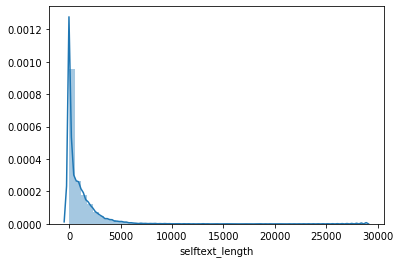

In [33]:
sns.distplot(main_reddit['selftext_length'], kde = 5)


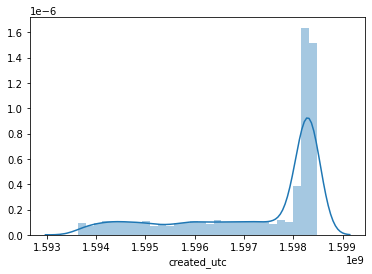

In [34]:
sns.distplot(main_reddit['created_utc'], kde = 5, norm_hist = True);

# Shows us what date most of our data comes from 

In [35]:
main_reddit.groupby(['subreddit']) [['selftext_length']].mean()

#On average, the self text tends to be more descriptive on relationship advice than on confession.

selftext_length
subreddit                 
0              1703.654770
1               194.805015

In [36]:
main_reddit.groupby(['subreddit']) [['title_length']].mean()

title_length
subreddit              
0             70.421908
1             78.447671

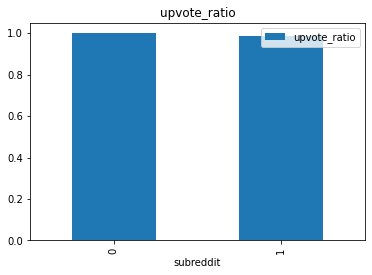

In [37]:
main_reddit.groupby(['subreddit']) [['upvote_ratio']].mean().plot(kind = 'bar', title = "upvote_ratio");

I wanted to evaluate if the upvote ratio(which is the number of votes a post gets) was stronger within any of our subreddits but they both seem to have around the same avg number of votes ( aprox ~98-99%) 

In [38]:
main_reddit.groupby(['subreddit']) [['num_comments']].mean()

num_comments
subreddit              
0             13.793875
1              3.950998

In [39]:
main_reddit.groupby(['subreddit']) [['num_comments']].mean().plot(kind = 'bar', title = "Number of comments", label = ['r_advice vs confessions']);

Number of comments is greater within relationship advice. This makes sense as people are on this particular subreddit to seek advice.

### Preprocessing:

- In this step we will be converting our text data into a matrix representation.
- We will be imploring our regex, tokenize, stemmatize and lemmatize functions and apply it to our data.
- Regex will allow us to find patterns in our data that we may possibly want to delete. We will then need to convert our data to a huge string in order to 
- This will help in converting our chosen column ('self text').

In [40]:
regex = RegexpTokenizer('\w+|\$[\d\.]+|\S+\s+\?\(\[')

In [41]:
token_ = main_reddit['selftext'].apply(regex.tokenize)

In [42]:
token_[0:2] 

0    [I, am, 23M, and, my, gf, is, 20F, and, I, rec...
1    [Well, I, kind, of, cut, off, someone, that, s...
Name: selftext, dtype: object

In [43]:
main_reddit['selftext'][:103]

0      I am 23M and my gf is 20F and I recently bough...
1      Well I kind of cut off someone that's been rea...
2      This might be rubbishly formatted as I’m on mo...
3      Broke up 3 months ago, he took 2.5 months to g...
4      I was in a serious relationship with this girl...
                             ...                        
98     I’m in an advanced degree program with this gi...
99     Should I be worried about this? In the last we...
100    First of all sorry if i make mistakes english ...
101    As a person (29f) who saw close people lose th...
102    I posted this on r/AmItheAsshole already but w...
Name: selftext, Length: 103, dtype: object

In [44]:
reddit_title = main_reddit['title'][0:]

In [45]:
#getting the title column specifically
reddit_selftext = main_reddit['selftext'][0:]

In [46]:
reddit_selftext[0:2]

0    I am 23M and my gf is 20F and I recently bough...
1    Well I kind of cut off someone that's been rea...
Name: selftext, dtype: object

- In the columns below I was still deciding whether to use self text or title for my predictor variable. 
- I wrote a for loop that removed stop words and tokenized as well. It only returned lower case words and deleted any other special characters. 
- These have been saved in the 'cleaned_self text' and 'cleaned_title' columns

In [47]:
stopwords = CountVectorizer(stop_words = 'english').get_stop_words()

In [48]:
#tokenize and remove non letters
# def selftextstring(selftxt):
newreddit = []
for reddit in reddit_selftext:
    selftext_letters = re.sub("[^a-zA-z]", " ", reddit) #tokenizing our data and returning only words, no special characters
    reddit_words = selftext_letters.lower().split() #making all words lower case
    
    stop_words = set(stopwords)           #stop words to be removed
    
    useful_words = [word for word in reddit_words if not word in stop_words]
    
    useful_words2 = (" ".join(useful_words))
    newreddit.append(useful_words2)
    
    
    

In [49]:
#tokenize and remove non letters

titlereddit = []
for reddit in reddit_title:
    title_letters = re.sub("[^a-zA-z]", " ", reddit) #tokenizing our data and returning only words, no special characters
    reddit_words = title_letters.lower().split() #making all words lower case
    usefulwords = (" ".join(reddit_words))
    titlereddit.append(usefulwords)
    

In [50]:
titlereddit[1]

'losing sleep over someone that doesn t even care lmao'

In [51]:
title = pd.DataFrame(titlereddit)

In [53]:
title.rename(columns = {0: 'cleaned_title'}, inplace = True)

In [54]:
main_reddit = pd.merge(main_reddit, title, how = 'left', left_index = True, right_index = True)

In [55]:
self_txt = pd.DataFrame(newreddit)

In [56]:
self_txt.rename(columns = {0: 'cleaned_self_text'}, inplace = True)

In [57]:
main_reddit = pd.merge(main_reddit, self_txt, how = 'left', left_index = True, right_index = True)

In [58]:
main_reddit.isnull().sum()

allow_live_comments            0
author                         0
author_flair_type              0
author_fullname                0
author_patreon_flair           0
author_premium                 0
can_mod_post                   0
contest_mode                   0
created_utc                    0
domain                         0
full_link                      0
id                             0
is_crosspostable               0
is_meta                        0
is_original_content            0
is_reddit_media_domain         0
is_robot_indexable             0
is_self                        0
is_video                       0
link_flair_background_color    0
link_flair_text_color          0
link_flair_type                0
locked                         0
media_only                     0
no_follow                      0
num_comments                   0
over_18                        0
parent_whitelist_status        0
permalink                      0
pinned                         0
pwls      

In [59]:
#checking most common words in our self text column

cv = CountVectorizer(stop_words = 'english', min_df= 2)
cv.fit(main_reddit['selftext'])

selftext_count = cv.transform(main_reddit['selftext'])
selftextcount_df = pd.DataFrame(selftext_count.todense(), columns = cv.get_feature_names())

In [60]:
selftextcount_df.sum().sort_values(ascending = False).head(30)

just            18379
like            16971
don             12557
know            11896
time            10788
really          10256
want            10110
ve               9383
feel             9379
said             8378
told             7372
relationship     7296
things           6937
didn             6924
removed          6689
friends          6684
got              5734
think            5659
years            5360
going            5344
friend           5023
did              4697
day              4694
love             4520
started          4514
make             4269
doesn            4220
talk             4218
work             4194
way              4150
dtype: int64

In [61]:
selftextcount_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', title = "Top 20 words in selftext");

***Is there a difference between our self text and cleaned/tokenized columns? Let's see!***

In [62]:
cv = CountVectorizer(min_df = 2)
cv.fit(main_reddit['cleaned_self_text'])

cleanedselftext_count = cv.transform(main_reddit['cleaned_self_text'])
cleanedselftextcount_df = pd.DataFrame(cleanedselftext_count.todense(), columns = cv.get_feature_names())

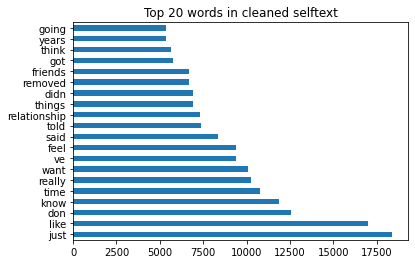

In [63]:
cleanedselftextcount_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', title = "Top 20 words in cleaned selftext");

- As we can see, there's no dfference at all! 
- Let's see if our have any predictive values as for our **title** columns as well

In [64]:
cv = CountVectorizer(stop_words= 'english', min_df = 2)
cv.fit(main_reddit['title'])

title_count = cv.transform(main_reddit['title'])
title_count_df = pd.DataFrame(title_count.todense(), columns = cv.get_feature_names())

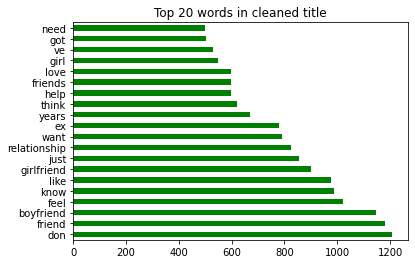

In [65]:
title_count_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', title = "Top 20 words in cleaned title", cmap = 'ocean');

***Assesment***
- So far the both columns seem to have a lot of predictive words that would help our model
- We also see that there's an overlap with certain words like **relationship, friends, and feel** 
- Overall, we will go with the 'title' data and see how our model does with that data.

### Modeling:

- Now we've done some preprocessing, let's go ahead and model our data! 
- We will be creating a Naives Bayes(Multinomial model) and a Logistic regression model and then compare our results.

### Logistic Regression:

In [68]:
X= main_reddit['cleaned_title']
y= main_reddit['subreddit']

In [156]:
y.value_counts(normalize = True) # null model.. the value we are trying to beat =

0    0.520667
1    0.479333
Name: subreddit, dtype: float64

In [69]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [70]:
cve = CountVectorizer(stop_words = 'english')

In [71]:
cve.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [72]:
X_train = cve.transform(X_train)

In [73]:
X_train_df_ = pd.DataFrame(X_train.toarray(),
                          columns=cve.get_feature_names())
X_train_df_.head()

__  aa  aasaaaaaaaaaaa  ab  abadoned  abandoned  abandoning  abandonment  \
0   0   0               0   0         0          0           0            0   
1   0   0               0   0         0          0           0            0   
2   0   0               0   0         0          0           0            0   
3   0   0               0   0         0          0           0            0   
4   0   0               0   0         0          0           0            0   

   abaout  abc  abhorrent  ability  able  abnormal  abort  aborted  abortion  \
0       0    0          0        0     0         0      0        0         0   
1       0    0          0        0     0         0      0        0         0   
2       0    0          0        0     0         0      0        0         0   
3       0    0          0        0     0         0      0        0         0   
4       0    0          0        0     0         0      0        0         0   

   abortions  abosulte  abrasive  abroad  abrupt  abruptly  absolute  \
0          0         0         0       0       0         0         0   
1          0         0         0       0       0         0         0   
2          0         0         0       0       0         0         0   
3          0         0         0       0       0         0         0   
4          0         0         0       0       0         0         0   

   absolutely  absurd  absurdly  absusive  abt  abuse  abused  abuser  \
0           0       0         0         0    0      0       0       0   
1           0       0         0         0    0      0       0       0   
2           0       0         0         0    0      0       0       0   
3           0       0         0         0    0      0       0       0   
4           0       0         0         0    0      0       0       0   

   abusers  abuses  abusing  abusive  academic  acc  accent  accentuate  \
0        0       0        0        0         0    0       0           0   
1        0       0        0        0         0    0       0           0   
2        0       0        1        0         0    0       0           0   
3        0       0        0        0         0    0       0           0   
4        0       0        0        0         0    0       0           0   

   accept  acceptable  accepted  accepting  accepts  access  accessed  \
0       0           0         0          0        0       0         0   
1       0           0         0          0        0       0         0   
2       0           0         0          0        0       0         0   
3       0           0         0          0        0       0         0   
4       0           0         0          0        0       0         0   

   accident  accidental  accidentally  accidently  accommodation  \
0         0           0             0           0              0   
1         0           0             0           0              0   
2         0           0             0           0              0   
3         0           0             0           0              0   
4         0           0             0           0              0   

   accomodation  accomplish  according  account  accountable  accounts  \
0             0           0          0        0            0         0   
1             0           0          0        0            0         0   
2             0           0          0        0            0         0   
3             0           0          0        0            0         0   
4             0           0          0        0            0         0   

   accusations  accused  accuses  accusing  accustomed  achieved  achievers  \
0            0        0        0         0           0         0          0   
1            0        0        0         0           0         0          0   
2            0        0        0         0           0         0          0   
3            0        0        0         0           0         0          0   
4            0        0        0    

In [74]:
X_test = cve.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=cve.get_feature_names())

In [75]:
lr_ = LogisticRegression(solver = 'liblinear')

In [76]:
lr_.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
lr_.score(X_train, y_train)

0.9211899313501144

In [78]:
lr_.score(X_test, y_test)

0.8310722913956514

***So what do these scores tell us about our Model so far?***

- It's slightly overfit. We need to add some hyper parameters to see if that will help our score
- We'll be grid searching after we add these new parameters

In [108]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [109]:
cv = CountVectorizer(stop_words = 'english')

In [111]:
cv.fit(X_train_)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [113]:
X_train = cv.transform(X_train_)

In [115]:
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cv.get_feature_names())

X_test = cve.transform(X_test_)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=cv.get_feature_names())

reddit_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

In [148]:
pipe_params = {
    'cv__max_features': [6_000],
    'cv__min_df': [1, 2],
    'cv__max_df': [.9, .95],
    'cv__ngram_range': [(1,1), (1,2)]
    }

In [149]:
gridsearch= GridSearchCV(reddit_pipe,
                        param_grid = pipe_params, cv = 5)

In [150]:
X_test.shape

(5381, 8390)

In [151]:
y_train.shape

(10925,)

In [152]:
X_train.shape

(10925, 8390)

In [153]:
gridsearch.fit(X_train_, y_train_)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepro

In [154]:
gridsearch.score(X_train_, y_train_)

0.9597254004576659

In [155]:
gridsearch.score(X_test_, y_test_)

0.8522579446199591

In [160]:
predict = gridsearch.predict(X_test_)

tn, fp, fn, tp = confusion_matrix(y_test_, predict).ravel()

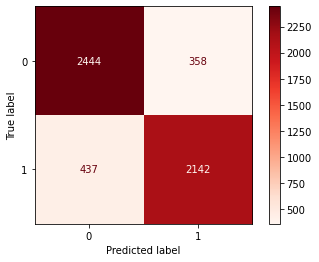

In [162]:
plot_confusion_matrix(gridsearch, X_test_, y_test_, cmap='Reds', values_format='d');

In [163]:
accuracy = (tp + tn)/(tp + tn+ fp + fn)
sensitivity = tp/ (tp + fp)
misclassification= 1 - accuracy           # how often is our model wrong
specificity = (tn/(tn +fp)) 

print (f'accuracy is: {accuracy}')       # how correct our model is
print (f'sensitivity is: {sensitivity}')   # how often we correctly predict yes
print (f'misclassification is: {misclassification}')
print (f'specificity is: {specificity}') # how often we correctly  

accuracy is: 0.8522579446199591
sensitivity is: 0.8568
misclassification is: 0.14774205538004093
specificity is: 0.8722341184867951


In [166]:
coefs = ({'column': X , 'coef': lr_.coef_}) 

In [169]:
coefs  #these are the X columns and the weight of their coef is how each X affects the model

{'column': 0                    long distance relationship gift ideas
 1        losing sleep over someone that doesn t even ca...
 2        i m struggling to stay friends with my popular...
 3        how to stop living in fear that my ex will cal...
 4        i still love my ex girlfriend but she wants no...
                                ...                        
 16301    in fifth grade i accidentally made fun of a gi...
 16302    sometimes i see the typo before i send it then...
 16303    i bullied a kid for several years in boy scout...
 16304    i ve been lying to my mom about how my brother...
 16305    i wore a confederate flag tie for a yearbook p...
 Name: cleaned_title, Length: 16306, dtype: object,
 'coef': array([[0.02509061, 0.49069127, 0.15174559, ..., 0.36332344, 0.09744143,
         0.41809003]])}

### Results of Logistic Regression Model:
**New Results with Grid Search CV**

- By adding some more features, we were able to increase our Training and testing score to 95% and 85% respectively.
- Our accuracy score is 85.22%
- This means that our model can correctly predict which subreddit a given post is coming from about 85% of the time on unseen data  
- I did play around with a few features and found this to be the best result. 
- While it scored a bit higher on our training data, it did go a good job of scoring way above our base line so we will keep this score and evaluate our next model; Naive Bayes!


### Naive Bayes Multinomial Model

In [213]:
Z_train, Z_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [214]:
# Let's type our Naives Bayes model, we will be using Multinomial Naive Bayes
cvec = CountVectorizer(stop_words = 'english')

In [215]:
cvec.fit(Z_train) # redefine x train

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [216]:
Xx_train = cvec.transform(Z_train)

In [217]:
X_traindf = pd.DataFrame(Xx_train.toarray(),
                          columns=cvec.get_feature_names())
X_traindf.head()

__  aa  aasaaaaaaaaaaa  ab  abadoned  abandoned  abandoning  abandonment  \
0   0   0               0   0         0          0           0            0   
1   0   0               0   0         0          0           0            0   
2   0   0               0   0         0          0           0            0   
3   0   0               0   0         0          0           0            0   
4   0   0               0   0         0          0           0            0   

   abaout  abc  abhorrent  ability  able  abnormal  abort  aborted  abortion  \
0       0    0          0        0     0         0      0        0         0   
1       0    0          0        0     0         0      0        0         0   
2       0    0          0        0     0         0      0        0         0   
3       0    0          0        0     0         0      0        0         0   
4       0    0          0        0     0         0      0        0         0   

   abortions  abosulte  abrasive  abroad  abrupt  abruptly  absolute  \
0          0         0         0       0       0         0         0   
1          0         0         0       0       0         0         0   
2          0         0         0       0       0         0         0   
3          0         0         0       0       0         0         0   
4          0         0         0       0       0         0         0   

   absolutely  absurd  absurdly  absusive  abt  abuse  abused  abuser  \
0           0       0         0         0    0      0       0       0   
1           0       0         0         0    0      0       0       0   
2           0       0         0         0    0      0       0       0   
3           0       0         0         0    0      0       0       0   
4           0       0         0         0    0      0       0       0   

   abusers  abuses  abusing  abusive  academic  acc  accent  accentuate  \
0        0       0        0        0         0    0       0           0   
1        0       0        0        0         0    0       0           0   
2        0       0        1        0         0    0       0           0   
3        0       0        0        0         0    0       0           0   
4        0       0        0        0         0    0       0           0   

   accept  acceptable  accepted  accepting  accepts  access  accessed  \
0       0           0         0          0        0       0         0   
1       0           0         0          0        0       0         0   
2       0           0         0          0        0       0         0   
3       0           0         0          0        0       0         0   
4       0           0         0          0        0       0         0   

   accident  accidental  accidentally  accidently  accommodation  \
0         0           0             0           0              0   
1         0           0             0           0              0   
2         0           0             0           0              0   
3         0           0             0           0              0   
4         0           0             0           0              0   

   accomodation  accomplish  according  account  accountable  accounts  \
0             0           0          0        0            0         0   
1             0           0          0        0            0         0   
2             0           0          0        0            0         0   
3             0           0          0        0            0         0   
4             0           0          0        0            0         0   

   accusations  accused  accuses  accusing  accustomed  achieved  achievers  \
0            0        0        0         0           0         0          0   
1            0        0        0         0           0         0          0   
2            0        0        0         0           0         0          0   
3            0        0        0         0           0         0          0   
4            0        0        0    

In [242]:
Xx_test = cve.transform(Z_test)
X_testdf = pd.DataFrame(Xx_test.toarray(),
                         columns=cvec.get_feature_names())

In [245]:
#create reddit pipeline

reddit_pipe_ = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [246]:
pipe_params_ = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,2), (1,3)],
    }

In [247]:
gs= GridSearchCV(reddit_pipe_,
                        param_grid = pipe_params_, cv = 5)

In [248]:
Xx_train.shape

(10925, 8390)

In [249]:
Xx_test.shape

(5381, 8390)

In [250]:
y_train.shape

(10925,)

In [252]:
gs.fit(Z_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [257]:
cross_val_score(reddit_pipe, Z_train, y_train, cv=3).mean() 

0.8393591644934238

In [258]:
#Best Score?

print(gs.best_score_)

0.8437528604118993


In [259]:
gs.score(Z_train, y_train)

0.877162471395881

In [260]:
gs.score(Z_test, y_test)

0.8494703586693924

In [264]:
pred= gs.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

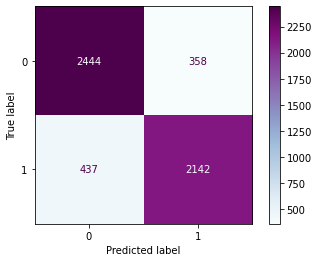

In [265]:
plot_confusion_matrix(gridsearch, Z_test, y_test, cmap='BuPu', values_format='d');

In [266]:
accuracy = (tp + tn)/(tp + tn+ fp + fn)
sensitivity = tp/ (tp + fp)
misclassification= 1 - accuracy           # how often is our model wrong
specificity = (tn/(tn +fp)) 

print (f'accuracy is: {accuracy}')       # how correct our model is
print (f'sensitivity is: {sensitivity}')   # how often we correctly predict yes
print (f'misclassification is: {misclassification}')
print (f'specificity is: {specificity}') # how often we correctly  

accuracy is: 0.8494703586693924
sensitivity is: 0.8451033944596177
misclassification is: 0.15052964133060764
specificity is: 0.8583154889364739


#### Naive Bayes Model Results:
So what does this model tell us?

- On our traning and testing sets, the NB model scored 87% for training set and 84% for our testing set.
- This is a much closer bias-variance trade off than our logistic regression model.
- As far as accuracy goes, it correctly predicted which post a subreddit was coming about 84.94% of the time and misclassified a post about 15% of the time.

### Evaluation of our models:

So which model performed better?

- This would depend on what we are looking to evaluate. 

- While we generally hold the notion that all models are wrong, some are actually quite useful. 

- We started with a baseline score of 52% relationship advice, to 47% confession and we were able to draw an accuracy score  between 84-85% on our models

- ***Since our main focus is on what classifer predicted more accurately, Logistic Regression has the slight edge over the Naives Bayes Model but not by much. Logistic regression came in at 85.2% accuracy and Naive Bayes was about 84.94%***


- I believe the methods used in both models (as outlined above) helped with increasing the score of our model. As mentioned, our model does suffer from a slight overfitting issue( especially within our Logistic Regression model) but with the help of grid search and adding specific parameters,we were able to cobmat this issue a bit more.

- We see the biggest difference in lowered bias-variance trade off in the NB model.

### Conclusions and Recommendations:

- Being that our level of success was based on accuracy we can say that our models were successful in predicting past the baseline models. 

- We applied several methods like count vectorizing, and grid searching to tune our parameters. 

- As far as the predictor words our clients would be interested in, we've listed the top 20 words that appeared within the titles. 

- Some of our top predictor words were "relationship", "feel", "friends", "boyfriend" "girlfirend", "years", and "help" so we can suggest to our clients that these are some of the words we can add to a targeted campaign to solicit new customers for them.

- As future steps are concerned, we can apply this modeling process to other types of subreddits that are within the interest of our clients in order to find more predictive words that can be used in a marketing context.

Thank you!



